In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.ndimage.interpolation import shift
import os
import seaborn as sns
import json

from pdftabextract.common import read_xml, parse_pages
from pdftabextract.clustering import zip_clusters_and_values
from pdftabextract.textboxes import border_positions_from_texts, split_texts_by_positions, join_texts
from pdftabextract.common import all_a_in_b, DIRECTION_VERTICAL
from pdftabextract.clustering import find_clusters_1d_break_dist
from pdftabextract.clustering import calc_cluster_centers_1d
from pdftabextract.extract import make_grid_from_positions
from pdftabextract.extract import fit_texts_into_grid, datatable_to_dataframe

from tabula import read_pdf
import pandas as pd

%matplotlib inline

In [2]:
from tables_detector.tables_detector_M import TableDetector

In [3]:

dat_path = "../../../dat/DATASETS/NL 14614829 - Claim File- image 1_Part 1/Output"
#dat_path = "../../../dat"

In [4]:
#pdf_file_name = 'Accident-Handwritten_V3.pdf'
#pdf_file_name = 'Deidentified medical record.pdf'
pdf_file_name = 'EgyptJHaematol_2012_37_4_207_134966_5.pdf'

base_file_name = os.path.splitext(pdf_file_name)[0]
page_num = 1
# Convert pdf to tiff
cmd = 'convert -density 300 ' + pdf_file_name + '[' + str(page_num-1) + ']' + ' ' + base_file_name+'.tiff'
#cmd = 'convert -density 150 ' + pdf_file_name + ' ' + base_file_name+'.tiff'
#os.system(cmd)

# Convert tiff to pdf sandwitch
cmd = 'tesseract' + ' ' + base_file_name+'.tiff' + ' ' + base_file_name+'_pdf_sand' + ' pdf'
#cmd = 'tesseract' + ' ' + 'Page 3.tiff' + ' ' + base_file_name+'_pdf_sand' + ' pdf'
#os.system(cmd)

# Convert pdf sandwitch to xml
xml_file = base_file_name+'.xml'
cmd = 'pdftohtml -c -hidden -xml' + ' ' + base_file_name+'_pdf_sand.pdf' + ' ' + xml_file
#os.system(cmd)

In [5]:
#!python3 -m http.server 8080 --bind 127.0.0.1

 http://127.0.0.1:8080/pdf2xml-viewer.html.

In [6]:

file_name = base_file_name+'.tiff'

#file_name = 'Page 3.jpg' # OK
#file_name = 'Page 5.jpg' # OK
#file_name = 'Page 7.jpg' # OK
#file_name = 'Page 8.jpg' # NOK
#file_name = 'Page 3.tiff' # NOK
#file_name = 'Page 3_mod.tiff' # NOK
#file_name = 'Page 3_mod_no_table.tiff' # NOK
#img_orig = cv2.imread(os.path.join(dat_path, file_name), 0)
img_orig = cv2.imread(file_name, 0)
img = (255 - img_orig.copy())/255
img = img[:, :-100]

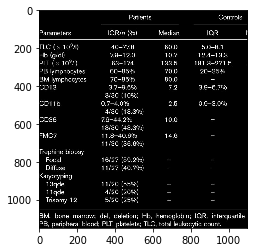

In [7]:
plt.imshow(img,cmap='gray')

In [8]:
img.shape

(1149, 1100)

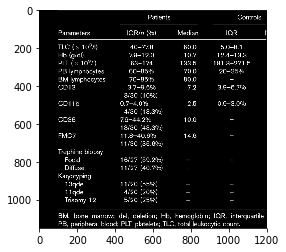

In [9]:

#img_new = cv2.resize(img, (img.shape[0], img.shape[1] + 100))
img_new = np.zeros((img.shape[0], img.shape[1] + 100))
img_new[:, 100:] = img
#img_new = np.concatenate(np.zeros((img.shape[0], 100)), img)
plt.imshow(img_new,cmap='gray')
img = img_new.copy()


/home/ahmad/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


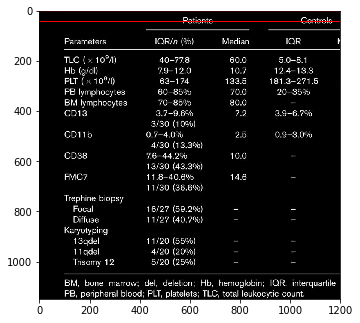

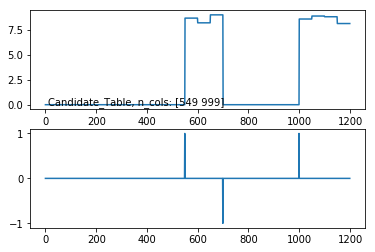

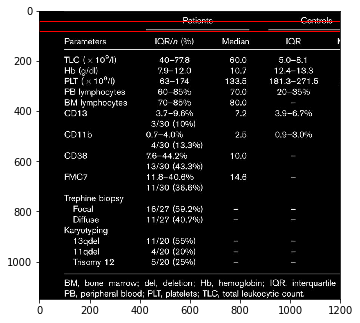

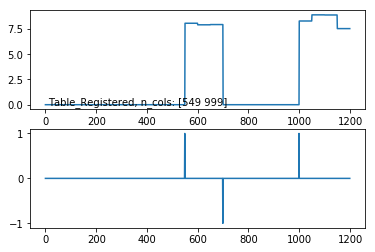

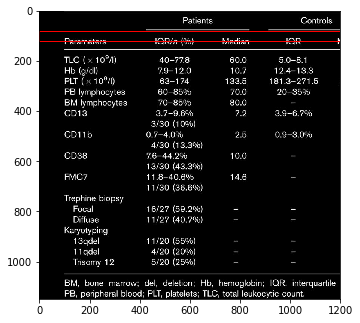

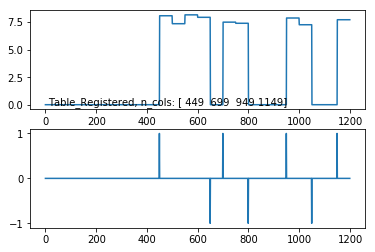

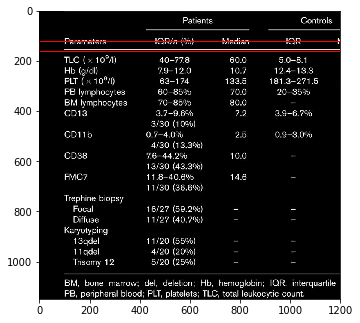

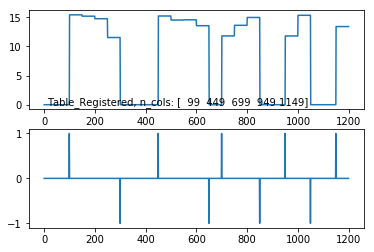

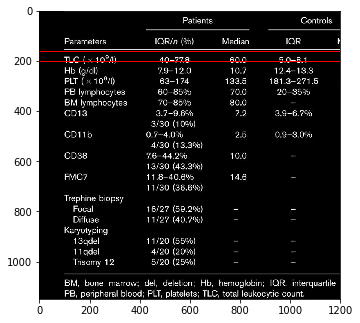

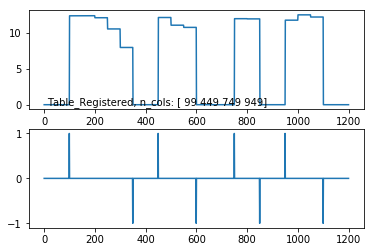

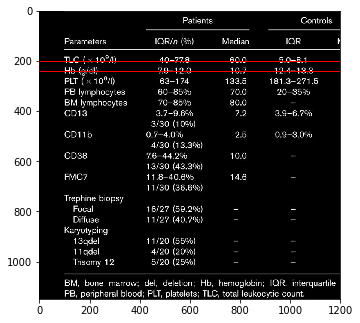

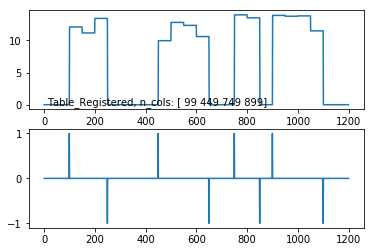

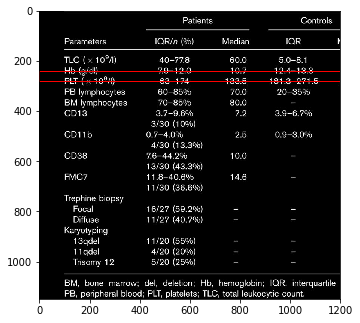

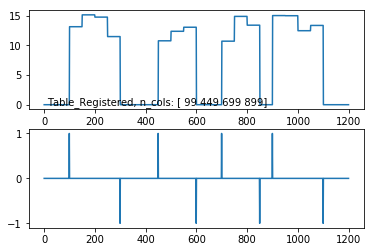

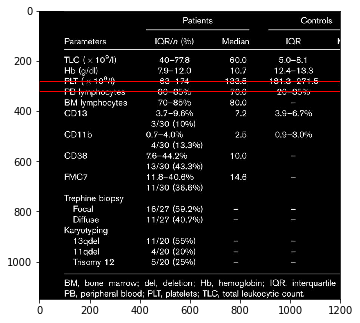

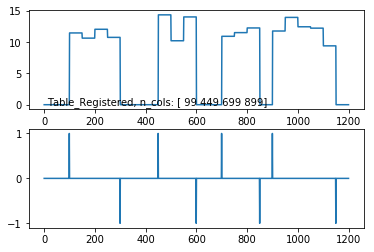

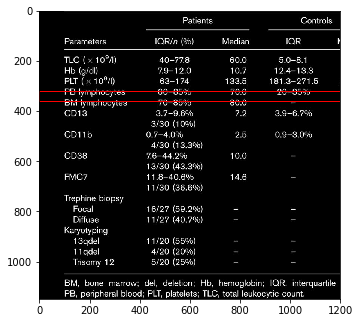

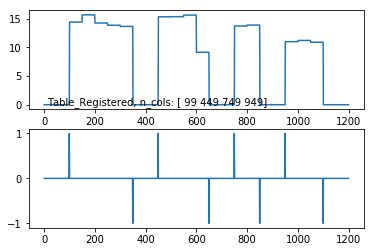

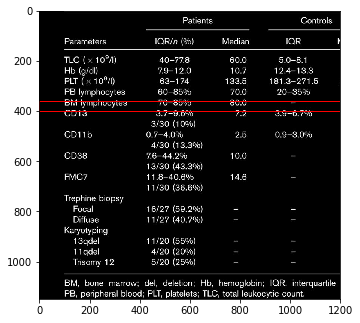

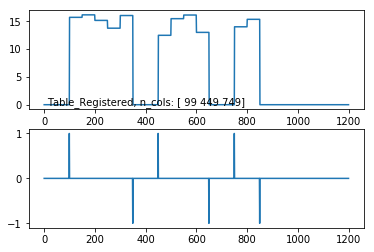

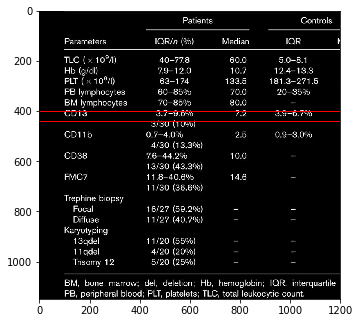

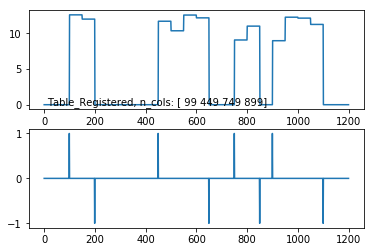

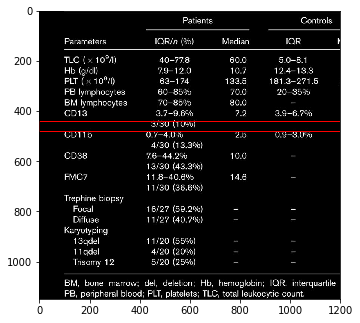

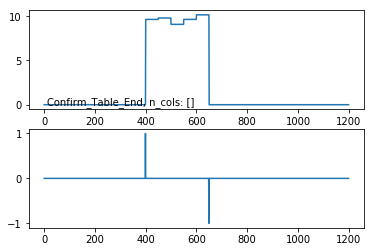

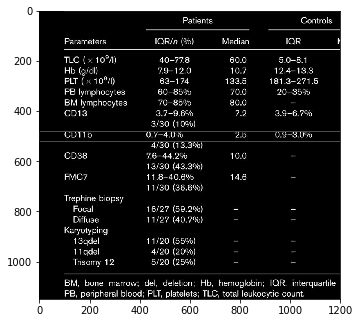

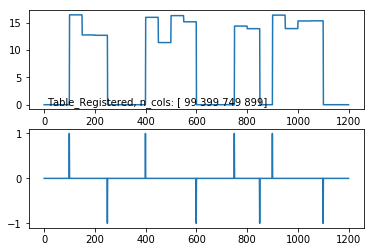

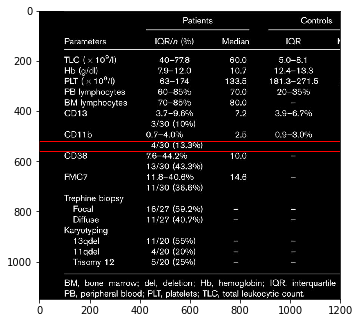

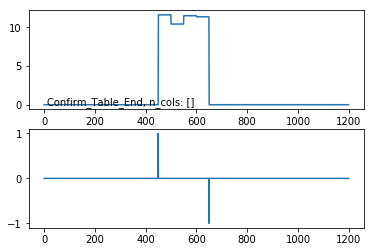

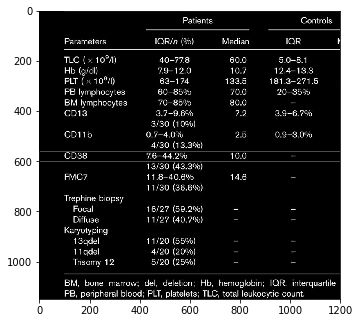

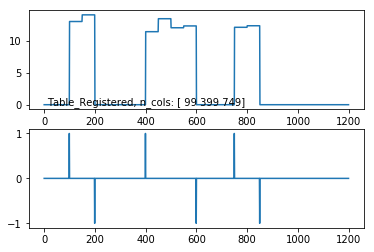

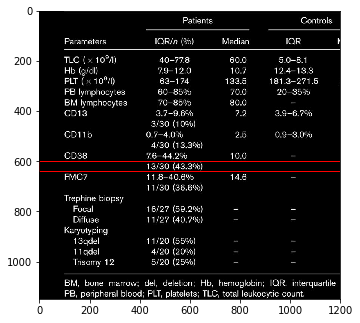

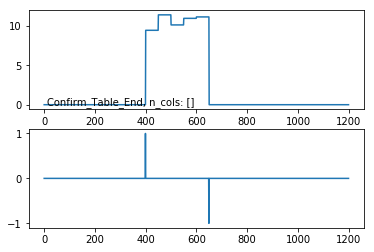

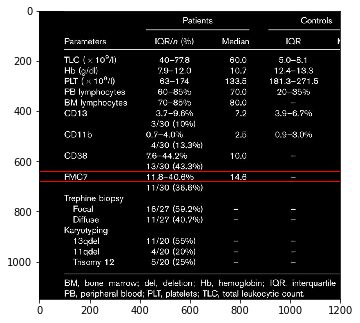

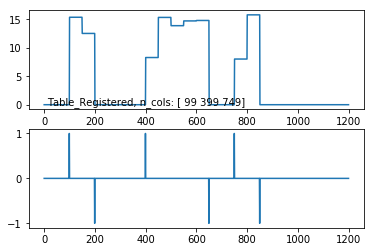

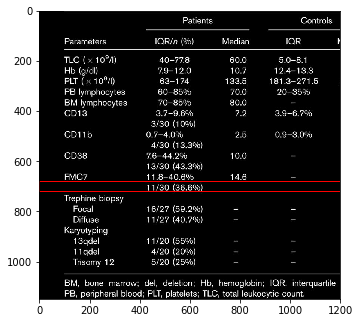

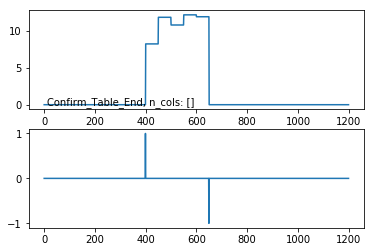

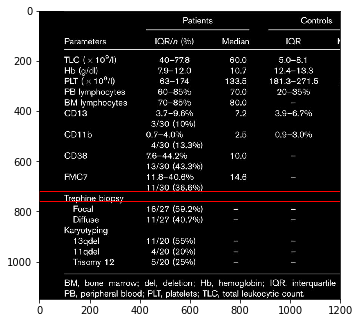

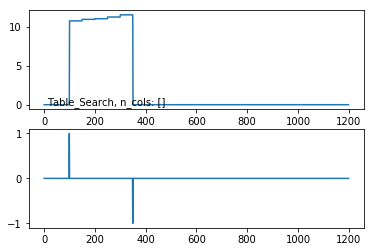

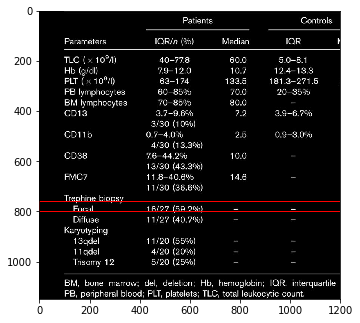

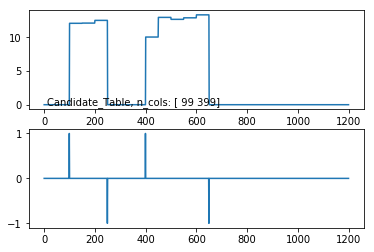

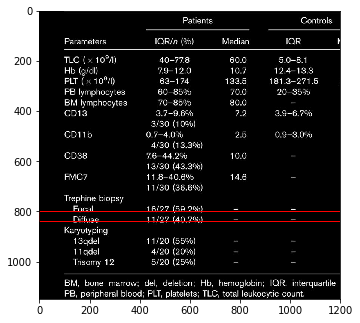

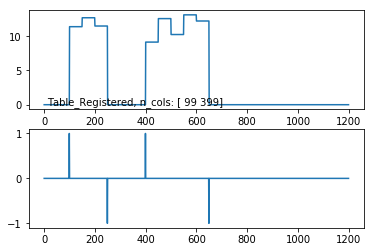

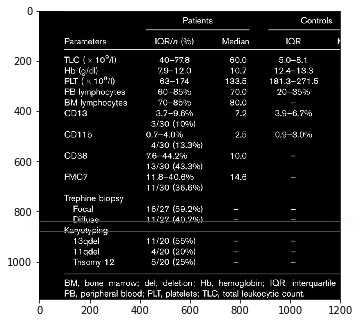

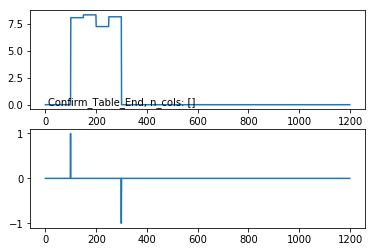

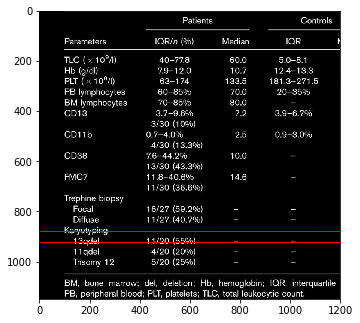

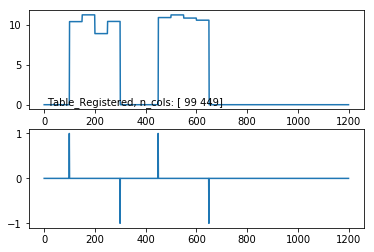

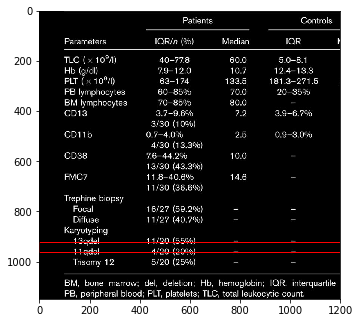

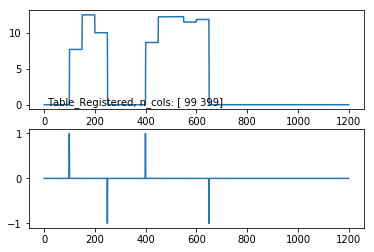

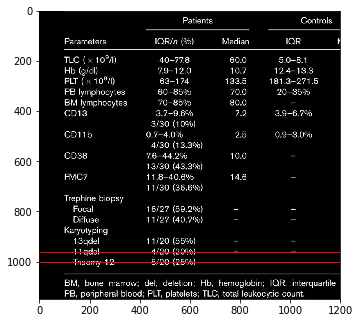

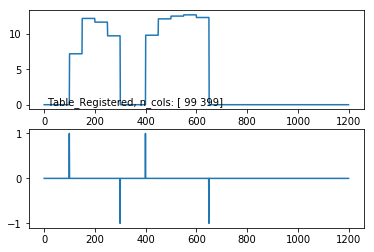

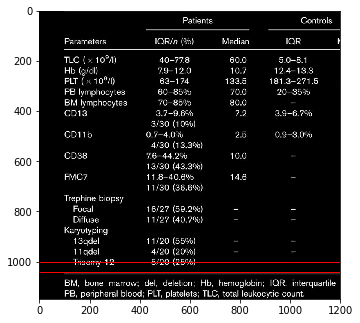

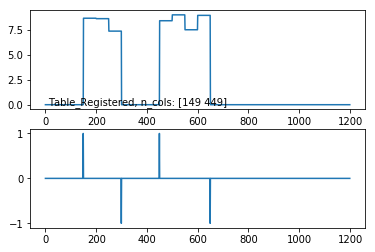

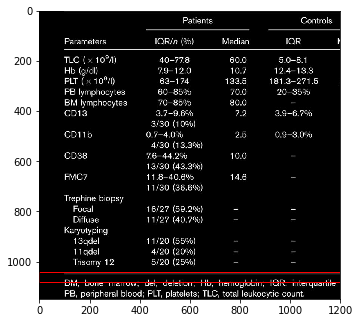

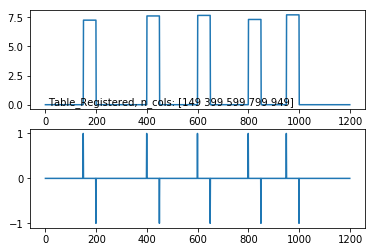

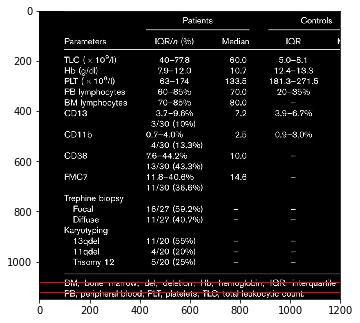

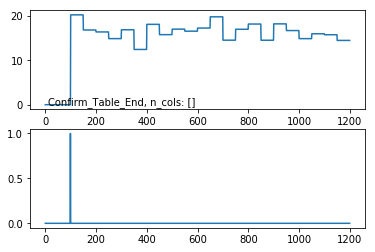

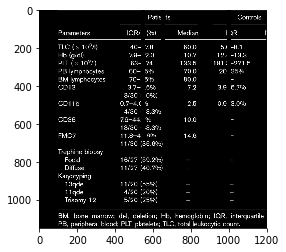

lefttop[0] must be smaller than rightbottom[0] to form a rectangle
Empty table



'{"data": []}'

In [10]:
verbose = True
# 3508x2379 ~ 90linesx25words ~ pixels/word = 96, pixels/line=40--> strip_height > 40 (*2 for header usually > 2 lines) (100) w_max_pool < 96 (50)
#tables_detector = TableDetector(verbose, strip_height=50, w_max_pool=75, min_col_width=250, ratio_clip_max=0.25)
tables_detector = TableDetector(verbose, strip_height=40, w_max_pool=50, min_col_width=100, ratio_clip_max=0.25)
tables = tables_detector.detect_tables(img)
tables_detector.visualize_tables(img, file_name)
tables_detector.fit_text_to_tables(xml_file)
#tables_detector.save_json(base_file_name)
list_of_json_tables = tables_detector.get_tables_in_json()
json.dumps({"data": list_of_json_tables})

In [11]:
tables

[{'table_start': 0, 'col_positions': array([549, 999, 651]), 'table_end': 680}]

In [12]:

df_tabula = read_pdf(pdf_file_name)# If tables with lines, better use tabula 

try:
    df_tabula.to_json(base_file_name+'.json')
    list_of_json_tables = [json.loads(df_tabula.to_json())]
    
except:
    verbose = False
    # 3508x2379 ~ 90linesx25words ~ pixels/word = 96, pixels/line=40--> strip_height > 40 (*2 for header usually > 2 lines) (100) w_max_pool < 96 (50)
    tables_detector = TableDetector(verbose, strip_height=50, w_max_pool=75, min_col_width=250, ratio_clip_max=0.25)
    tables = tables_detector.detect_tables(img)
    tables_detector.visualize_tables(img_orig, file_name)
    tables_detector.fit_text_to_tables(xml_file)
    #tables_detector.save_json(base_file_name)
    list_of_json_tables = tables_detector.get_tables_in_json()
    
json.dumps({"data": list_of_json_tables})

'{"data": [{"Unnamed: 0": {"0": null, "1": null, "2": "Parameters", "3": "TLC (x 10\\u00b0/I)", "4": "Hb (g/dl)", "5": "PLT (x 10\\u00b0!)", "6": "PB lymphocytes", "7": "BM lymphocytes", "8": "CD13", "9": null, "10": "CD11b", "11": null, "12": "CD38", "13": null, "14": "FMC7", "15": null, "16": "Trephine biopsy", "17": "Focal", "18": "Diffuse", "19": "Karyotyping", "20": "13qdel", "21": "11qdel", "22": "Trisomy 12"}, "Unnamed: 1": {"0": "Patients", "1": null, "2": "IQR/n (%)", "3": "40-77.8", "4": "7.9-12.0", "5": "63-174", "6": "60-85%", "7": "70-85%", "8": "3.7-9.6%", "9": "3/30 (10%)", "10": "0.7-4.0%", "11": "4/30 (13.3%)", "12": "7.6-44.2%", "13": "13/30 (43.3%)", "14": "11.8-40.6%", "15": "11/30 (36.6%)", "16": null, "17": "16/27 (59.2%)", "18": "11/27 (40.7%)", "19": null, "20": "11/20 (55%)", "21": "4/20 (20%)", "22": "5/20 (25%)"}, "Unnamed: 2": {"0": null, "1": null, "2": "Median", "3": "60.0", "4": "10.7", "5": "133.5", "6": "70.0", "7": "80.0", "8": "7.2", "9": null, "10": 

In [13]:
df_tabula

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Patients,NaN,Controls,NaN
1,NaN,NaN,NaN,NaN,NaN
2,Parameters,IQR/n (%),Median,IQR,Median
3,TLC (x 10°/I),40-77.8,60.0,5.0-8.1,6.5
4,Hb (g/dl),7.9-12.0,10.7,12.4-13.3,12.9
5,PLT (x 10°!),63-174,133.5,181.3-271.5,231.5
6,PB lymphocytes,60-85%,70.0,20-35%,24.0
7,BM lymphocytes,70-85%,80.0,-,=~
8,CD13,3.7-9.6%,7.2,3.9-6.7%,5.2
9,NaN,3/30 (10%),NaN,NaN,NaN


In [14]:
with open(base_file_name+'.json', 'w') as outfile:  
    json.dump({"data": list_of_json_tables}, outfile)